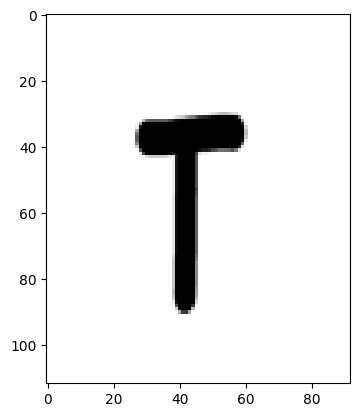

In [ ]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Change directory path to your character dataset
classes = os.listdir('./char/train')
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.Resize((112, 92)),  # Add resize to ensure consistent dimensions
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92) / 2 + .5, cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] * len(classes)
    vec[x] = 1
    return vec

# Count total number of images first
train_count = sum([len(os.listdir(f'./char/train/{c}')) for c in classes])
test_count = sum([len(os.listdir(f'./char/test/{c}')) for c in classes])

train = test = 0
train_x, train_y = ([0]) * train_count, ([0]) * train_count
test_x, test_y = ([0]) * test_count, ([0]) * test_count

# Load and preprocess training data
for c in os.listdir('./char/train/'):
    for faces in os.listdir('./char/train/'+c):
        img = Image.open('./char/train/'+c+'/'+faces).convert('L')
        img = img.resize((92, 112))  # Resize image
        img = np.array(img)
        train_x[train] = img.flatten()
        train_y[train] = c_to_i(c)
        train += 1

# Load and preprocess test data
for c in os.listdir('./char/test/'):
    for faces in os.listdir('./char/test/'+c):
        img = Image.open('./char/test/'+c+'/'+faces).convert('L')
        img = img.resize((92, 112))  # Resize image
        img = np.array(img)
        test_x[test] = img.flatten()
        test_y[test] = c_to_i(c)
        test += 1

# Stack and convert to numpy arrays
train_x = np.stack([x if isinstance(x, np.ndarray) else np.zeros(112*92) for x in train_x])
test_x = np.stack([x if isinstance(x, np.ndarray) else np.zeros(112*92) for x in test_x])
test_y = np.array(test_y, dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

# Normalize the image data
train_x = train_x / 255.0
test_x = test_x / 255.0

# Show sample image
show_img(train_x[0])

In [ ]:
class CharacterModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(CharacterModel, self).__init__()
        
        self.linear1 = torch.nn.Linear(D_in, 512)
        self.relu1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(0.3)
        self.linear2 = torch.nn.Linear(512, 256)
        self.relu2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(0.3)
        self.linear3 = torch.nn.Linear(256, D_out)
        
    def forward(self, x):
        x = self.dropout1(self.relu1(self.linear1(x)))
        x = self.dropout2(self.relu2(self.linear2(x)))
        return self.linear3(x)

model = CharacterModel(len(train_x[0]), len(classes))

steps = 1000
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Starting training...")
for i in range(steps):
    optimizer.zero_grad()
    y_hat = model(torch.FloatTensor(train_x))
    loss = criterion(y_hat, torch.LongTensor(train_y))
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 10 == 0:
        with torch.no_grad():
            train_pred = torch.argmax(y_hat, dim=1)
            accuracy = (train_pred == torch.LongTensor(train_y)).float().mean()
            print(f'Step [{i+1}/{steps}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

model.eval()
with torch.no_grad():
    test_pred = model(torch.FloatTensor(test_x))
    test_accuracy = (torch.argmax(test_pred, dim=1) == torch.LongTensor(test_y)).float().mean()
    print(f'\nTest Accuracy: {test_accuracy.item():.4f}')

model_save_path = 'model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'classes': classes,
    'input_size': len(train_x[0]),
    'output_size': len(classes)
}, model_save_path)

print(f"\nModel saved to {model_save_path}")

Starting training...
Step [10/1000], Loss: 3.4350, Accuracy: 0.1111
Step [20/1000], Loss: 1.7851, Accuracy: 0.4444
Step [30/1000], Loss: 1.2600, Accuracy: 0.4444
Step [40/1000], Loss: 0.7793, Accuracy: 0.6667
Step [50/1000], Loss: 0.9042, Accuracy: 0.6667
Step [60/1000], Loss: 0.7178, Accuracy: 0.8889
Step [70/1000], Loss: 0.3115, Accuracy: 1.0000
Step [80/1000], Loss: 0.1867, Accuracy: 1.0000
Step [90/1000], Loss: 0.2948, Accuracy: 1.0000
Step [100/1000], Loss: 0.2382, Accuracy: 0.8889
Step [110/1000], Loss: 0.0422, Accuracy: 1.0000
Step [120/1000], Loss: 0.0484, Accuracy: 1.0000
Step [130/1000], Loss: 0.0200, Accuracy: 1.0000
Step [140/1000], Loss: 0.0230, Accuracy: 1.0000
Step [150/1000], Loss: 0.0608, Accuracy: 1.0000
Step [160/1000], Loss: 0.0021, Accuracy: 1.0000
Step [170/1000], Loss: 0.0318, Accuracy: 1.0000
Step [180/1000], Loss: 0.0118, Accuracy: 1.0000
Step [190/1000], Loss: 0.0263, Accuracy: 1.0000
Step [200/1000], Loss: 0.0157, Accuracy: 1.0000
Step [210/1000], Loss: 0.046

C:\Users\talak\AppData\Local\Temp\ipykernel_23932\3967814951.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('character_recognition_model.pth')

Step [100/1000], Loss: 0.0110
Step [200/1000], Loss: 0.0102
Step [300/1000], Loss: 0.0094
Step [400/1000], Loss: 0.0086
Step [500/1000], Loss: 0.0078
Step [600/1000], Loss: 0.0071
Step [700/1000], Loss: 0.0064
Step [800/1000], Loss: 0.0058
Step [900/1000], Loss: 0.0053
Step [1000/1000], Loss: 0.0049


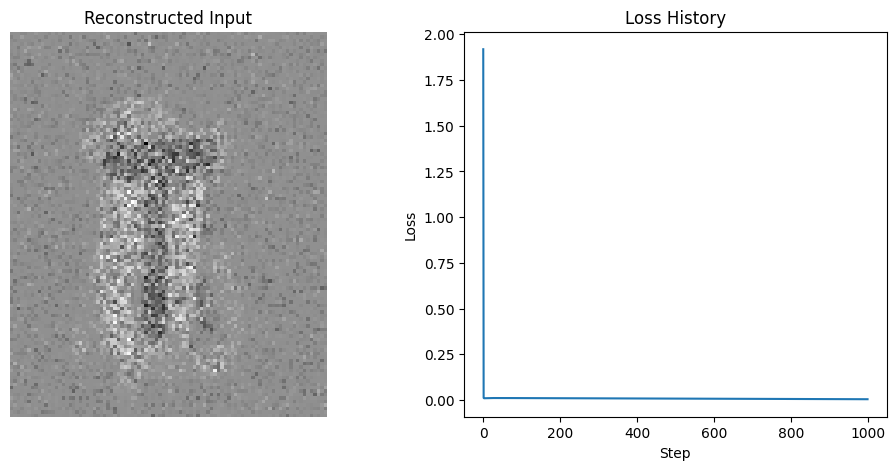


Inverting class: s1
Step [100/1000], Loss: 0.0118
Step [200/1000], Loss: 0.0115
Step [300/1000], Loss: 0.0111
Step [400/1000], Loss: 0.0106
Step [500/1000], Loss: 0.0100
Step [600/1000], Loss: 0.0095
Step [700/1000], Loss: 0.0089
Step [800/1000], Loss: 0.0083
Step [900/1000], Loss: 0.0077
Step [1000/1000], Loss: 0.0072


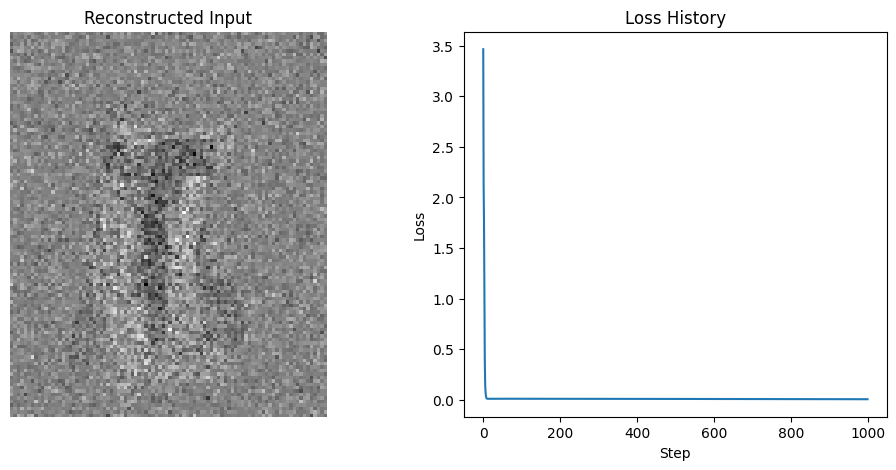


Inverting class: s2
Step [100/1000], Loss: 0.0121
Step [200/1000], Loss: 0.0117
Step [300/1000], Loss: 0.0113
Step [400/1000], Loss: 0.0108
Step [500/1000], Loss: 0.0102
Step [600/1000], Loss: 0.0097
Step [700/1000], Loss: 0.0091
Step [800/1000], Loss: 0.0085
Step [900/1000], Loss: 0.0079
Step [1000/1000], Loss: 0.0073


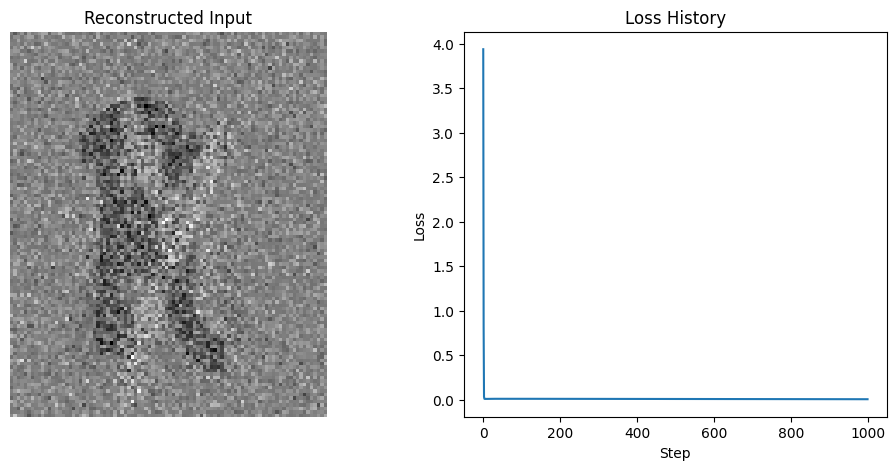


Inverting class: s3
Step [100/1000], Loss: 0.0113
Step [200/1000], Loss: 0.0103
Step [300/1000], Loss: 0.0093
Step [400/1000], Loss: 0.0084
Step [500/1000], Loss: 0.0076
Step [600/1000], Loss: 0.0068
Step [700/1000], Loss: 0.0062
Step [800/1000], Loss: 0.0056
Step [900/1000], Loss: 0.0051
Step [1000/1000], Loss: 0.0047


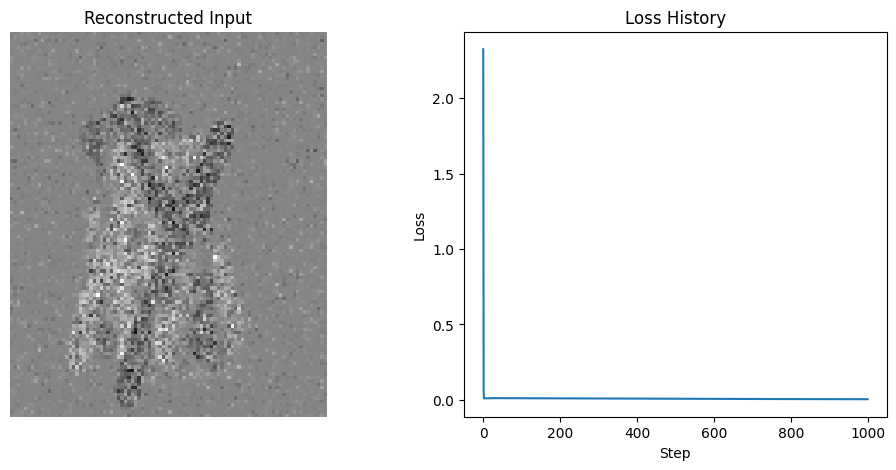


Inverting class: s4
Step [100/1000], Loss: 0.0113
Step [200/1000], Loss: 0.0108
Step [300/1000], Loss: 0.0102
Step [400/1000], Loss: 0.0095
Step [500/1000], Loss: 0.0089
Step [600/1000], Loss: 0.0082
Step [700/1000], Loss: 0.0075
Step [800/1000], Loss: 0.0068
Step [900/1000], Loss: 0.0062
Step [1000/1000], Loss: 0.0056


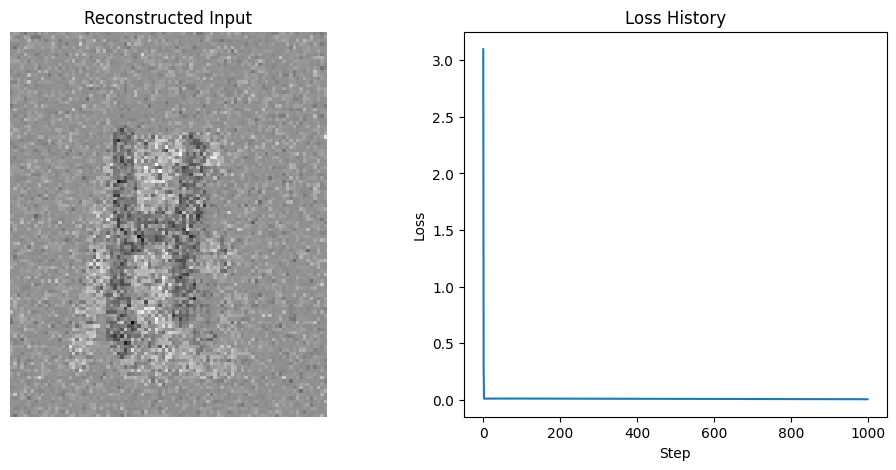


Inverting class: s5
Step [100/1000], Loss: 0.0110
Step [200/1000], Loss: 0.0101
Step [300/1000], Loss: 0.0091
Step [400/1000], Loss: 0.0083
Step [500/1000], Loss: 0.0075
Step [600/1000], Loss: 0.0068
Step [700/1000], Loss: 0.0062
Step [800/1000], Loss: 0.0056
Step [900/1000], Loss: 0.0052
Step [1000/1000], Loss: 0.0048


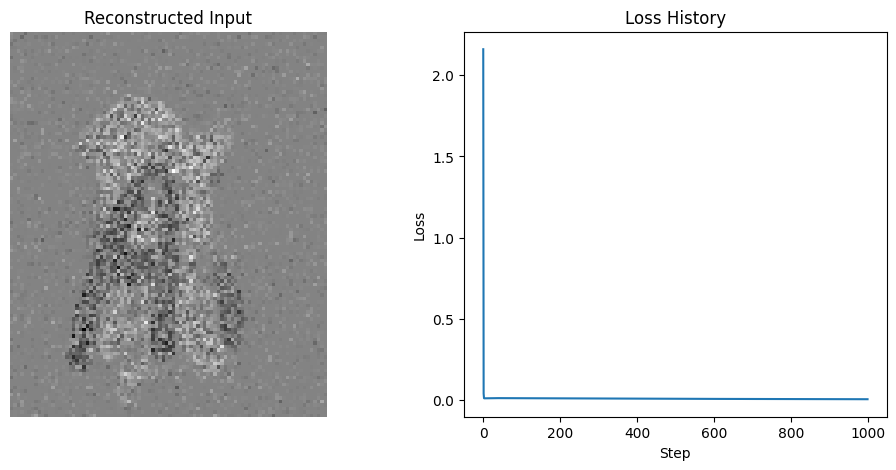


Inverting class: s6
Step [100/1000], Loss: 0.0115
Step [200/1000], Loss: 0.0110
Step [300/1000], Loss: 0.0104
Step [400/1000], Loss: 0.0097
Step [500/1000], Loss: 0.0091
Step [600/1000], Loss: 0.0084
Step [700/1000], Loss: 0.0077
Step [800/1000], Loss: 0.0071
Step [900/1000], Loss: 0.0065
Step [1000/1000], Loss: 0.0059


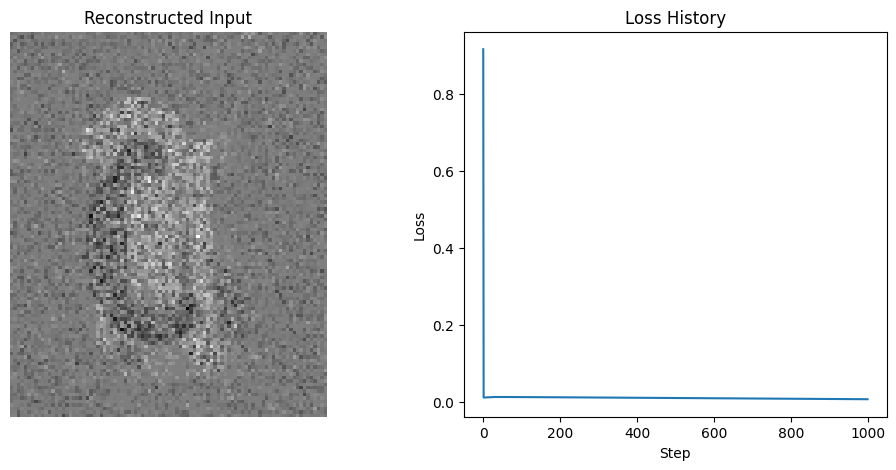


Inverting class: s7
Step [100/1000], Loss: 0.0113
Step [200/1000], Loss: 0.0106
Step [300/1000], Loss: 0.0099
Step [400/1000], Loss: 0.0091
Step [500/1000], Loss: 0.0083
Step [600/1000], Loss: 0.0077
Step [700/1000], Loss: 0.0070
Step [800/1000], Loss: 0.0065
Step [900/1000], Loss: 0.0060
Step [1000/1000], Loss: 0.0055


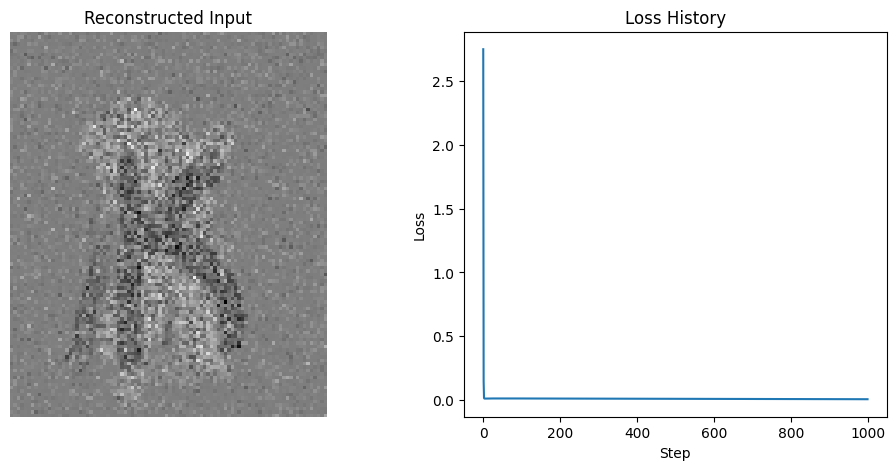


Inverting class: s8
Step [100/1000], Loss: 0.0111
Step [200/1000], Loss: 0.0099
Step [300/1000], Loss: 0.0089
Step [400/1000], Loss: 0.0079
Step [500/1000], Loss: 0.0070
Step [600/1000], Loss: 0.0062
Step [700/1000], Loss: 0.0055
Step [800/1000], Loss: 0.0050
Step [900/1000], Loss: 0.0045
Step [1000/1000], Loss: 0.0041


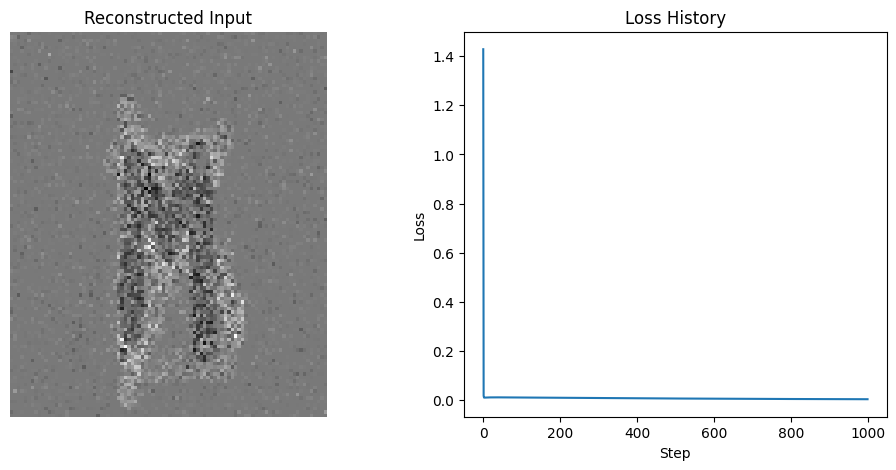


Inverting class: s9
Step [100/1000], Loss: 0.0115
Step [200/1000], Loss: 0.0110
Step [300/1000], Loss: 0.0105
Step [400/1000], Loss: 0.0100
Step [500/1000], Loss: 0.0094
Step [600/1000], Loss: 0.0089
Step [700/1000], Loss: 0.0083
Step [800/1000], Loss: 0.0077
Step [900/1000], Loss: 0.0071
Step [1000/1000], Loss: 0.0066


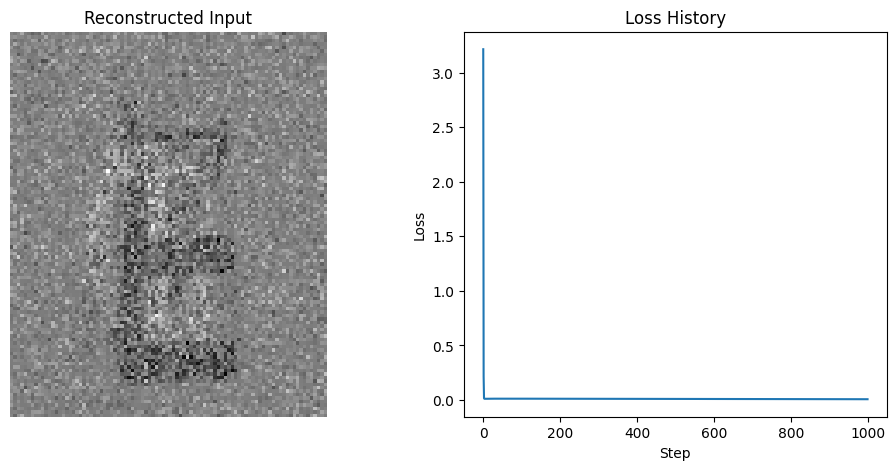

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def invert_model(model, target_class, num_steps=1000, learning_rate=0.1, l2_reg=0.0001):
    """
    Performs model inversion to generate an input that activates the target class.
    
    Args:
        model: Trained CharacterModel
        target_class: Integer class index to invert
        num_steps: Number of optimization steps
        learning_rate: Learning rate for optimization
        l2_reg: L2 regularization strength
    
    Returns:
        reconstructed_input: The generated input image
        loss_history: List of loss values during optimization
    """
    model.eval()  # Set model to evaluation mode
    
    # Initialize random input
    x = torch.randn(1, 112*92, requires_grad=True)
    optimizer = torch.optim.Adam([x], lr=learning_rate)
    
    loss_history = []
    
    # Create target tensor
    target = torch.tensor([target_class], dtype=torch.long)
    
    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(x)
        
        # Calculate loss (cross-entropy + L2 regularization)
        ce_loss = torch.nn.functional.cross_entropy(out\put, target)
        l2_loss = l2_reg * torch.norm(x)
        loss = ce_loss + l2_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Store loss
        loss_history.append(loss.item())
        
        # Print progress
        if (step + 1) % 100 == 0:
            print(f'Step [{step+1}/{num_steps}], Loss: {loss.item():.4f}')
    
    # Reshape and normalize the reconstructed input
    reconstructed = x.detach().numpy().reshape(112, 92)
    reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())
    
    return reconstructed, loss_history

def visualize_inversion(reconstructed_input, loss_history, save_path=None):
    """
    Visualizes the results of model inversion.
    
    Args:
        reconstructed_input: Generated input image
        loss_history: List of loss values during optimization
        save_path: Optional path to save the visualization
    """
    plt.figure(figsize=(12, 5))
    
    # Plot reconstructed image
    plt.subplot(1, 2, 1)
    plt.imshow(reconstructed_input, cmap='gray')
    plt.title('Reconstructed Input')
    plt.axis('off')
    
    # Plot loss history
    plt.subplot(1, 2, 2)
    plt.plot(loss_history)
    plt.title('Loss History')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def invert_all_classes(model, classes, output_dir='inverted_chars'):
    """
    Performs model inversion for all classes and saves the results.
    
    Args:
        model: Trained CharacterModel
        classes: List of class names
        output_dir: Directory to save results
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    for i, class_name in enumerate(classes):
        print(f"\nInverting class: {class_name}")
        reconstructed, loss_history = invert_model(model, i)
        
        # Save visualization
        save_path = os.path.join(output_dir, f'{class_name}_inversion.png')
        visualize_inversion(reconstructed, loss_history, save_path)
        
        # Save reconstructed image
        img_save_path = os.path.join(output_dir, f'{class_name}_reconstructed.png')
        plt.imsave(img_save_path, reconstructed, cmap='gray')

# Example usage:
def run():
    # Load the saved model
    checkpoint = torch.load('character_recognition_model.pth')
    model = CharacterModel(checkpoint['input_size'], checkpoint['output_size'])
    model.load_state_dict(checkpoint['model_state_dict'])
    classes = checkpoint['classes']
    
    # Invert single class
    target_class = 0  # First class
    reconstructed, loss_history = invert_model(model, target_class)
    visualize_inversion(reconstructed, loss_history)
    
    # Or invert all classes
    invert_all_classes(model, classes)
run()